In [157]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline


from imblearn.combine import SMOTETomek
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from imblearn.under_sampling import CondensedNearestNeighbour

from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import thanh as t


In [158]:
df = pd.read_csv('data/Chicago_Merged.csv')
df = df.dropna()

In [159]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Police Districts,Police Beats,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,0,10778514.0,HZ544820,2016-12-08 17:23:00,079XX S MAY ST,0820,THEFT,$500 AND UNDER,APARTMENT,False,...,20.0,230.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
1,1,11411914.0,JB390837,2018-08-12 22:00:00,013XX W 76TH ST,0560,ASSAULT,SIMPLE,APARTMENT,False,...,20.0,230.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
2,2,11510038.0,JB519570,2018-11-17 14:49:00,079XX S BISHOP ST,502P,OTHER OFFENSE,FALSE/STOLEN/ALTERED TRP,STREET,False,...,20.0,230.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
3,3,11495832.0,JB500163,2018-11-02 08:20:00,083XX S HALSTED ST,0484,BATTERY,PRO EMP HANDS NO/MIN INJURY,STREET,False,...,20.0,236.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0
4,4,11501552.0,JB508324,2018-11-08 11:00:00,087XX S RACINE AVE,0810,THEFT,OVER $500,SIDEWALK,False,...,9.0,244.0,Auburn Gresham,4.0,27.6,28.3,18.5,41.9,15528.0,74.0


### Crime Definitions:
 * **THEFT**: Steal something which belongs to someone else.
 * **BATTERY**: Cause physical harm to another person.
 * **CRIMINAL**: Destroying or damaging property.
 * **ASSAULT**: Threaten physical harm to another person.
 * **DECEPTIVE PRACTICE**: Attempt to deceive or defraud a person or business. 
 * **BURGLARY**: Breaking into someone's house with the intent of stealing.
 * **ROBBERY**: Stealing from someone with threats of violence (e.g. mugging).

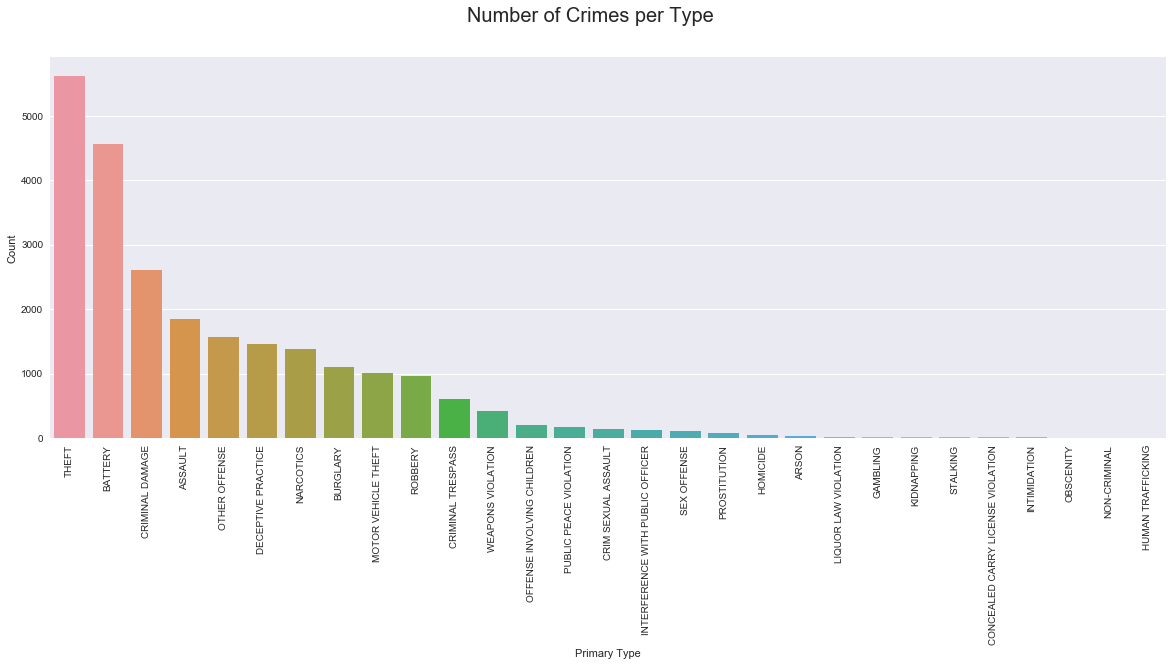

In [160]:
names = df['Primary Type'].value_counts().keys().tolist()
counts = df['Primary Type'].value_counts().tolist()
df_count = pd.DataFrame()
df_count['Primary Type'] = names
df_count['Count'] = counts
df_count.head(3)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
sns.barplot(y = df_count['Count'], x = df_count['Primary Type'], ax = axes)
axes.set_xlabel("Crime Count")
axes.set_xlabel("Primary Type")
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)
fig.suptitle('Number of Crimes per Type', fontsize=20)
plt.show()

### Violent Crimes
* **BATTERY**
* **ASSAULT**
* **ROBBERY**
* **CRIMINAL SEXUAL ASSAULT**
* **KIDNAPPING**
* **HOMICIDE**
* **ARSON**

In [161]:
violent_crime = df[df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]
nonviolent_crime = df[~df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]

**The following function  helps us to determine the location of crime(including residential and non residential areas) and based on which we can analyse that in which location crime occurs frequently.**

In [162]:
def crime_locations(data, description):
    names = data.value_counts().keys().tolist()
    counts = data.value_counts().tolist()
    total = len(data)
    print(description)
    for i in range(5):
        percentage = (counts[i] / total) * 100
        print('{}: {}%'.format(names[i], int(round(percentage, 0))))
    print()

In [163]:
print('Top 5 locations of crime by percentage of crime which occured there')
crime_locations(df['Location Description'], 'All Crime')
crime_locations(violent_crime['Location Description'], 'Violent Crime')
crime_locations(nonviolent_crime['Location Description'], 'Nonviolent Crime')

Top 5 locations of crime by percentage of crime which occured there
All Crime
STREET: 23%
RESIDENCE: 16%
APARTMENT: 13%
SIDEWALK: 9%
OTHER: 4%

Violent Crime
APARTMENT: 20%
STREET: 17%
RESIDENCE: 16%
SIDEWALK: 15%
ALLEY: 3%

Nonviolent Crime
STREET: 26%
RESIDENCE: 16%
APARTMENT: 10%
SIDEWALK: 6%
OTHER: 5%



### INFERENCES:
**VIOLENT CRIME**: As seen in the above result, the percentage of violent crime is highest in the apartment which is 20%. The main reason could be that apartments might be more approachable for a criminal to break in and perform theft, sexual assault,etc.

**NON VIOLENT CRIME**: Crime such as kidnapping or battery are most commonly seen on streets (26%). The reason behind this is that most criminals may tend to kidnap people on some isolated streets.

In [164]:
df['Location Description'].value_counts()

STREET                                             5588
RESIDENCE                                          3858
APARTMENT                                          3142
SIDEWALK                                           2088
OTHER                                               932
PARKING LOT/GARAGE(NON.RESID.)                      716
SMALL RETAIL STORE                                  590
RESTAURANT                                          584
RESIDENTIAL YARD (FRONT/BACK)                       463
ALLEY                                               454
VEHICLE NON-COMMERCIAL                              440
RESIDENCE PORCH/HALLWAY                             436
DEPARTMENT STORE                                    408
RESIDENCE-GARAGE                                    399
SCHOOL, PUBLIC, BUILDING                            336
GAS STATION                                         331
GROCERY FOOD STORE                                  267
PARK PROPERTY                                   

# Percentage of Arrest for each crime sub-group

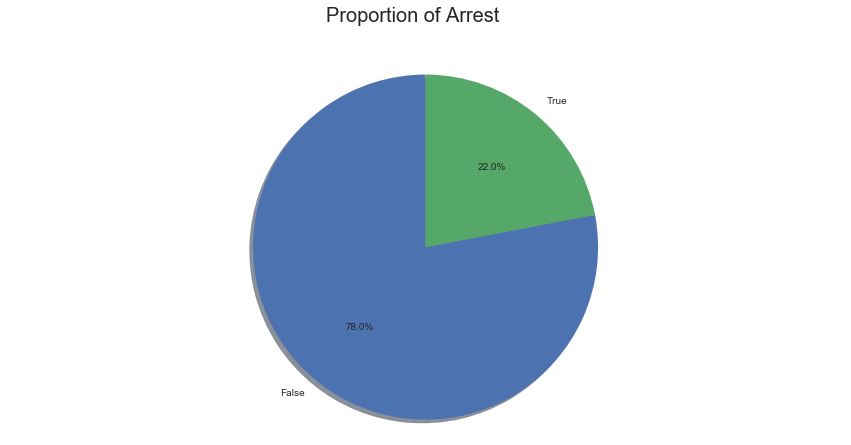

In [165]:
df_nonviolent_arrest = t.crime_proximity(nonviolent_crime, 'Arrest', 0)
t.pie(df_nonviolent_arrest, 'Percentage')

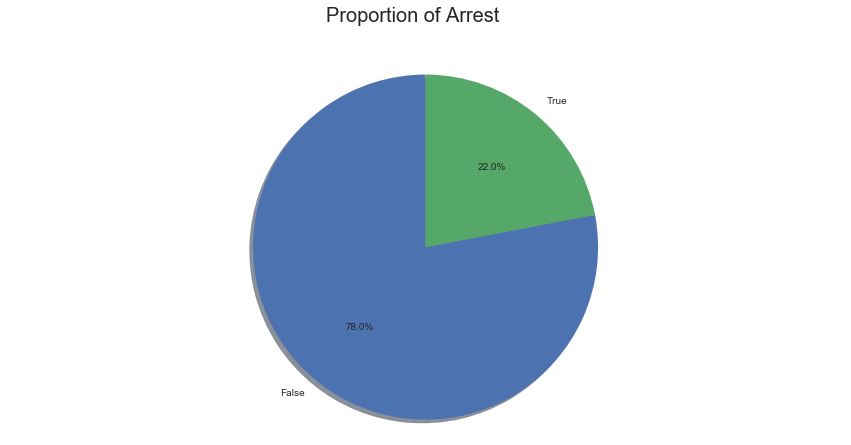

In [166]:
df_violent_arrest = t.crime_proximity(violent_crime, 'Arrest', 0)
t.pie(df_nonviolent_arrest, 'Percentage')

### INFERENCES:
A very small percentage of arrest in all the three categories can be noticed above. Though all the values for arrest rates are low but rate for non violent crime is higher than violent crime. 
Although, the police and government should be strict in arresting criminals for all types of crimes but looking at a low arrest rate of violent crime is non satisfactory. This may be due to ignorance of so many crimes occuring,lack of security, higher rate of crimes which cannot be handled by the police.



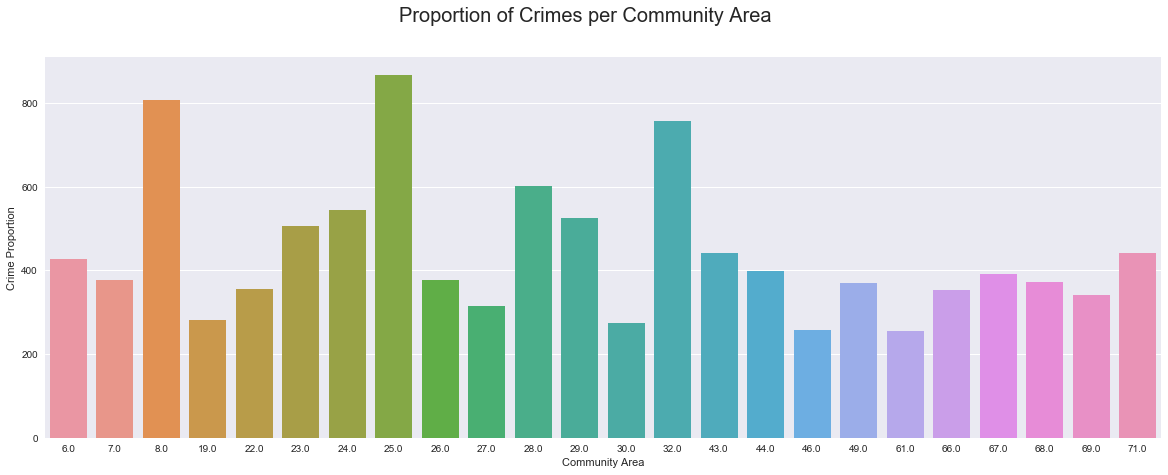

In [167]:
df_comm_area_count = t.crime_proximity(nonviolent_crime, 'Community Area', 1.5)
t.community_proximity_bar(df_comm_area_count, 'Count')

**The following function  helps us to determine the percentage of crime distribution in top five community areas(Austin,Near North Side,Loop,Near West Side, North Lawndale).**

In [168]:
def distribution(data, description):
    names = data.value_counts().keys().tolist()
    counts = data.value_counts().tolist()
    total = len(data)
    print(description)
    for i in range(5):
        print('{}: {}'.format(names[i], counts[i]))
    print()

In [169]:
print('Top 5 community areas for crime\n')
distribution(df['COMMUNITY AREA NAME'], 'All Crime')
distribution(violent_crime['COMMUNITY AREA NAME'], 'Violent Crime')
distribution(nonviolent_crime['COMMUNITY AREA NAME'], 'Nonviolent Crime')

Top 5 community areas for crime

All Crime
Austin: 1409
Near North Side: 1020
Loop: 907
Near West Side: 804
North Lawndale: 791

Violent Crime
Austin: 543
South Shore: 327
North Lawndale: 267
Auburn Gresham: 258
Humboldt park: 253

Nonviolent Crime
Austin: 866
Near North Side: 806
Loop: 758
Near West Side: 602
West Town: 545



### INFERENCES:
Maximum number of crimes occur in Austin followed by Near North Side, Loop, Near West Side, North Lawndale. This may be due to the absence of police stations, isolated areas, unemployment, poverty which in some cases may lead to attempt in crime like robbery, theft, assault and other crimes. 

## DATA PRE-PROCESSING




***One-hot Encoding*** : One hot encoding is a process of converting categorical variables into a form that is provided to machine learning algorithm to do a easier job. 
In this project, we are using one-hot encoder to convert following features:
* *Location Description*: The describes about location of crime.
* *Community Area* : Name of the community are where crime occurred.
* *Primary Type* : The type of crime committed.

In [170]:
oh_enc = OneHotEncoder(sparse=False)
location_description_enc = oh_enc.fit_transform(df['Location Description'].values.reshape(-1, 1))
print(location_description_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [171]:
oh_enc = OneHotEncoder(sparse=False)
community_area_enc = oh_enc.fit_transform(df['COMMUNITY AREA NAME'].values.reshape(-1, 1))
print(community_area_enc[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [172]:
oh_enc = OneHotEncoder(sparse=False)
crime_type_enc = oh_enc.fit_transform(df['Primary Type'].values.reshape(-1, 1))
print(crime_type_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0.]


***Ordinal Encoding***- This uses a single column to represent classes. Here, ordinal encoding is a string ( True or False) which states  whether the police have made an arrest for this crime. We will convert this feature using an original encoder so that it can be used in a machine learning model.

In [173]:
ord_enc = OrdinalEncoder()
arrest_ord_enc = ord_enc.fit_transform(df['Arrest'].values.reshape(-1, 1))

In [174]:
ord_enc = OrdinalEncoder()
domestic_ord_enc = ord_enc.fit_transform(df['Domestic'].values.reshape(-1, 1))

***Bucketing*** - Bucketing means putting in different categories. A new feature 'income' is being created from the 'per capita income' where 'high', 'medium' and 'low' are identified as buckets. 
* *An inbuilt library from sklearn- "KBinsDiscretizer" is being used.*

In [175]:
def bin_edges(d, title):
    print(title, 'ranges of each bin:')
    for i in range(1, len(d)):
        print('Bin {}: {} to {}'.format(i, d[i - 1], d[i]))
    print('')

In [176]:
disc = KBinsDiscretizer(n_bins=3, encode='ordinal')
bucket_income = disc.fit_transform(df['PER CAPITA INCOME '].values.reshape(-1, 1))
bin_edges(disc.bin_edges_[0], 'Bucket income')
df['bucket_income'] = bucket_income
print('Distribution of values in bins:')
print(df['bucket_income'].value_counts())

Bucket income ranges of each bin:
Bin 1: 8201.0 to 15957.0
Bin 2: 15957.0 to 24336.0
Bin 3: 24336.0 to 88669.0

Distribution of values in bins:
1.0    8266
2.0    8213
0.0    7648
Name: bucket_income, dtype: int64


In [177]:
disc = KBinsDiscretizer(n_bins=5, encode='onehot-dense')
bucket_latitude = disc.fit_transform(df['Latitude'].values.reshape(-1, 1))
bin_edges(disc.bin_edges_[0], 'Latitude')
disc = KBinsDiscretizer(n_bins=5, encode='onehot-dense')
bucket_longitude = disc.fit_transform(df['Longitude'].values.reshape(-1, 1))
bin_edges(disc.bin_edges_[0], 'Longitude')

Latitude ranges of each bin:
Bin 1: 41.647924640999996 to 41.759324223600004
Bin 2: 41.759324223600004 to 41.81373832039999
Bin 3: 41.81373832039999 to 41.881512491
Bin 4: 41.881512491 to 41.918329869
Bin 5: 41.918329869 to 42.022536147

Longitude ranges of each bin:
Bin 1: -87.914869723 to -87.7230788748
Bin 2: -87.7230788748 to -87.6838677316
Bin 3: -87.6838677316 to -87.64979390760001
Bin 4: -87.64979390760001 to -87.62378751860001
Bin 5: -87.62378751860001 to -87.525749601



## CREATING SYNTHETIC FEATURES
### Feature Engineering: 
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Synthetic features is a form of feature engineering. We create folloeing features:
* Time of day
* Weekend
* Violent crime

In [178]:
def time_of_day(x):
    time = x[-8:]
    hour = int(time[:2])
    if hour <= 6:
        return 'early morning'
    if hour > 6 and hour < 18:
        return 'day'
    return 'night'

df['hour'] = df['Date'].map(lambda x: time_of_day(x))
df['hour'].value_counts()

day              12452
night             7510
early morning     4165
Name: hour, dtype: int64

In [179]:
oh_enc = OneHotEncoder(sparse=False)
hour_enc = oh_enc.fit_transform(df['hour'].values.reshape(-1, 1))

In [180]:
def is_weekend(x):
    dt = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    day = dt.weekday()
    if day < 5:
        return 0
    return 1

In [181]:
df['is_weekend'] = df['Date'].map(lambda x: is_weekend(x))
df['is_weekend'].value_counts()

0    17247
1     6880
Name: is_weekend, dtype: int64

In [182]:
weekend_enc = df['is_weekend'].values.reshape(-1, 1)

In [183]:
def is_violent(x):
    if x in ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON']:
        return 1
    return 0

In [184]:
df['is_violent'] = df['Primary Type'].map(lambda x: is_violent(x))
df['is_violent'].value_counts()

0    16516
1     7611
Name: is_violent, dtype: int64

In [185]:
violent_enc = df['is_violent'].values.reshape(-1, 1)

## Predicting Where Crimes Occur
This is framed as a three-class classification problem, where the labels are: low wealth, moderate wealth, and high wealth areas. This feature was created by binning the income per capita of the community area in which the crime occured.

### Creating Training and Test Data
The training data will be used to train the model, while the test data for evaluation. A seperate test set simulates how the model generalises to new data and helps us find models that are overfitting to training data.
The processed data is combined into 'X (features) array' and 'y (labels) array'. This will then be split into train and test sets by the sklearn train_test_split function.

In [186]:
X = np.concatenate((arrest_ord_enc, hour_enc, weekend_enc, violent_enc, domestic_ord_enc, location_description_enc, crime_type_enc, bucket_latitude, bucket_longitude), axis=1)
y = bucket_income
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=1)

* **Logistic regression**-Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression is estimating the parameters of a logistic model (a form of binary regression).
* **Support vector Machine**-Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
* **K nearest neighbors**-KNN is a non-parametric, lazy learning algorithm. When we say a technique is non-parametric, it means that it does not make any assumptions about the underlying data. In other words, it makes its selection based off of the proximity to other data points regardless of what feature the numerical values represent. Being a lazy learning algorithm implies that there is little to no training phase. Therefore, we can immediately classify new data points as they present themselves.
* **Neural Network**-Neural networks (NN), also called artificial neural networks (ANN) are a subset of learning algorithms within the machine learning field that are loosely based on the concept of biological neural networks.Basically, an ANN comprises of the following components: 
- An input layer that receives data and pass it on
- A hidden layer
- An output layer
- Weights between the layers

### Logistic Regression (baseline)
The simplist type of model, logisitc regression, will be compared to the other techniques to find the best performing model.

In [187]:
def plot_confusion_matrix(title, actual, predicted, classes, figsize = (10,7)):
    matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(
        matrix, index=classes, columns=classes, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    title = title + ' Confusion Matrix'
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

Train Accuracy:  0.7129593810444874
Test Accuracy:  0.718501326259947


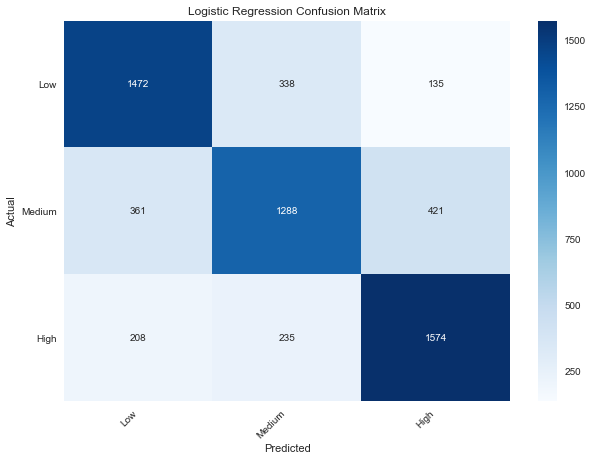

In [188]:
model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)
print('Train Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))
model_pred = model.predict(X_test)
model_classes = ['Low', 'Medium', 'High']
plot_confusion_matrix('Logistic Regression', y_test, model_pred, model_classes)

#### Baseline Results
An almost 72% accuracy isn't too bad for a three-class classification problem, as random chance is only 33% accuracy. The model is definitely learning useful information from the data to make predictions. The train and test accuracies indicate that the model isn't overfitting.

### Support Vector Machine Model (SVM)

In [ ]:
svm_model = SVC(gamma='auto')
svm_model.fit(X_train, y_train)
print('Train Accuracy: ', svm_model.score(X_train, y_train))
print('Test Accuracy: ', svm_model.score(X_test, y_test))
model_pred = svm_model.predict(X_test)
plot_confusion_matrix('SVM', y_test, model_pred, model_classes)

#### SVM Results
Was the slowest model to train and had the weakest performance of any model. It did correctly predict medium income with a better accuracy than the baseline, but was worse at predicting crime that would occur in low and high income areas. The train and test accuracies indicate that the model isn't overfitting. Surprisingly, the test accuracy is marginally higher than the train.

### K-Nearest Neighbors Model

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
print('Train Accuracy: ', knn_model.score(X_train, y_train))
print('Test Accuracy: ', knn_model.score(X_test, y_test))
model_pred = knn_model.predict(X_test)
plot_confusion_matrix('KNN', y_test, model_pred, model_classes)

#### KNN Results
The KNN performed better than both the baseline and SVM at predicting crime in moderately-weathly areas, but performed worse than the baseline at about low and high income predictions. Overall, the accuracy of the KNN was slightly worse than the baseline. The train and test accuracies indicate that the model is overfitting as the test accuracy is about 8% lower than the train accuracy.

### Neural Network Model

In [ ]:
nn_model = MLPClassifier(random_state=0, max_iter=10)
nn_model.fit(X_train, y_train)
print('Train Accuracy: ', nn_model.score(X_train, y_train))
print('Test Accuracy: ', nn_model.score(X_test, y_test))
model_pred = nn_model.predict(X_test)
plot_confusion_matrix('Neural Network', y_test, model_pred, model_classes)

#### Neural Network Results
This model performed the best of all, with an almost 5% accuracy improvement over the baseline model. It made up that ground with a high level of accuracy for moderate-income areas, but performed to a comparable level to the baseline on low and high income predictions. The train and test accuracies indicate that the model isn't overfitting.

#### Neural Network Iteration Testing

In [ ]:
train_scores = []
test_scores = []
iterations = []

for i in range(10, 51, 10):
    mlp = MLPClassifier(random_state=0, max_iter=i)
    mlp.fit(X_train, y_train)
    train_scores.append(mlp.score(X_train, y_train))
    test_scores.append(mlp.score(X_test, y_test))
    iterations.append(i)

In [ ]:
plt.figure(figsize=(8, 6))    
plt.plot(iterations, train_scores, label='Train')
plt.plot(iterations, test_scores, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Neural network performance with iterations')
leg = plt.legend()
plt.grid(True)
plt.show()

**Iteration Observations**  
Despite the complaints of the model not reaching convergence, the best result for test accuracy is actually the lowest number of iterations. Above 10 iterations the model starts overfitting the training data.

#### Neural Network Solver Testing

In [ ]:
train_scores = []
test_scores = []
solvers = ['lbfgs','sgd', 'adam']
for i in solvers:
    mlp = MLPClassifier(solver=i, random_state=0, max_iter=10)
    mlp.fit(X_train, y_train)
    train_scores.append(mlp.score(X_train, y_train))
    test_scores.append(mlp.score(X_test, y_test))

In [ ]:
n_groups = 3
index = np.arange(n_groups)
plt.figure(figsize=(8, 6))
bar_width = 0.4
plt.bar(index, train_scores, bar_width, color='#5da5d1', label='Train')
plt.bar(index + bar_width, test_scores, bar_width, color='#08306b', label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Solver')
plt.title('Neural network performance with solvers')
leg = plt.legend()
plt.xticks(index + bar_width/2, solvers)
plt.grid(True)
plt.tight_layout()
plt.show()

**Solver observations**  
The adam solver, which is the default for the MLPClassifier, has a noticible improvement in accuracy over the others for this problem.

## Predicting violent crime
This is a binary classification problem, where the labels are: nonviolent and violent. The features include: the time of day, whether an arrest occured, a description of the location, and what community area it took place in. Since this is now a binary classification problem, we can now easily use Receiver Operating Characteristic (ROC) Area Under Curve (AUC) as an additional metric to accuracy.

In [ ]:
X = np.concatenate((arrest_ord_enc, hour_enc, weekend_enc, domestic_ord_enc, location_description_enc, bucket_latitude, bucket_longitude, community_area_enc, bucket_income), axis=1)
y = df['is_violent'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
encoder = OneHotEncoder()
encoder.fit([[0], [1]])
y_test_proba = encoder.transform(y_test.reshape(-1, 1)).toarray()

### Logistic Regression (baseline)

In [ ]:
model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train, y_train)
print('Train Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))
model_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
model_classes = ['Nonviolent', 'Violent']
plot_confusion_matrix('Logistic Regression', y_test, model_pred, model_classes, figsize = (8,6))

#### Baseline Results
A 76% accuracy isn't incredible for a binary classification task, but the model is learning something from the data to perform 26% above random chance. Interestingly, the accuracy for nonviolent crime is significantly higher than for violent crime. The train and test accuracies indicate that the model isn't overfitting.

### Support Vector Machine Model

In [ ]:
svm_model = SVC(gamma='auto', probability=True)
svm_model.fit(X_train, y_train)
print('Train Accuracy: ', svm_model.score(X_train, y_train))
print('Test Accuracy: ', svm_model.score(X_test, y_test))
model_pred = svm_model.predict(X_test)
probabilities = svm_model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('SVM', y_test, model_pred, model_classes, figsize = (8,6))

#### SVM Results
Accuracy and ROC AUC are both slightly lower than the baseline model, but interestingly it has the lowest number of false positives of any of the models (nonviolent crimes predicted incorrectly as violent). Unfortunately, it didn't do well at predicting violent crime: far more violent crimes were incorrectly predited to be nonviolent. The train and test accuracies indicate that the model isn't overfitting.

### K-Nearest Neighbours Model

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
print('Train Accuracy: ', knn_model.score(X_train, y_train))
print('Test Accuracy: ', knn_model.score(X_test, y_test))
model_pred = knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('KNN', y_test, model_pred, model_classes, figsize = (8,6))

#### KNN Results
The KNN model was the weakest performing out of all the models. It was inferior in every aspect to the baseline model. The train and test accuracies indicate that the model is overfitting as the test accuracy is about 8% lower than the train accuracy.

#### Trying different numbers of neighbors
Perhaps the default setting of 5 neighbors wasn't the best for this problem?

In [ ]:
train_scores = []
test_scores = []
iterations = []

for i in range(2, 8):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))
    iterations.append(i)

plt.figure(figsize=(8, 6))    
plt.plot(iterations, train_scores, label='Train')
plt.plot(iterations, test_scores, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('KNN performance with number of neighbors')
leg = plt.legend()
plt.grid(True)
plt.show()

#### Finding the best value of K
The default K of 5 seems perfectly reasonable, but it appears the results were slightly better at 6.

### Naive Bayes Classifier Model

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
probabilities = nb_model.predict_proba(X_test)
model_pred = nb_model.predict(X_test)
print('Train Accuracy: ', nb_model.score(X_train, y_train))
print('Test Accuracy: ', nb_model.score(X_test, y_test))
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('NB', y_test, model_pred, model_classes, figsize = (8,6))

#### Naive Bayes Results
The Naive Bayes model has solid, but unremarkable performance. It performed better than the KNN model, but slightly worse than the baseline in all cases. The train and test accuracies indicate that the model isn't overfitting.

### Neural Network Model

In [ ]:
nn_model = MLPClassifier(random_state=0, max_iter=10)
nn_model.fit(X_train, y_train)
print('Train Accuracy: ', nn_model.score(X_train, y_train))
print('Test Accuracy: ', nn_model.score(X_test, y_test))
model_pred = nn_model.predict(X_test)
probabilities = model.predict_proba(X_test)
print('ROC AUC: ', roc_auc_score(y_test_proba, probabilities))
plot_confusion_matrix('Neural Network', y_test, model_pred, model_classes, figsize = (8,6))

#### Neural Network Results
This model performed the best in every metric, and was the only model which was able to correctly predict more violent crimes than it got wrong. The train and test accuracies indicate that the model isn't overfitting.

#### Neural Network Iteration Testing
The goal is to find the best number of iterations using the test set accuracy as the metric.

In [ ]:
train_scores = []
test_scores = []
iterations = []

for i in range(10, 51, 10):
    mlp = MLPClassifier(random_state=0, max_iter=i)
    mlp.fit(X_train, y_train)
    train_scores.append(mlp.score(X_train, y_train))
    test_scores.append(mlp.score(X_test, y_test))
    iterations.append(i)

plt.figure(figsize=(8, 6))    
plt.plot(iterations, train_scores, label='Train')
plt.plot(iterations, test_scores, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Neural network performance with iterations')
leg = plt.legend()
plt.grid(True)
plt.show()

#### Iteration Testing
The neural network starts overfitting immediately after 10 iterations, so keeping the iterations low is ideal in this case.

In [ ]:
df = pd.read_csv('data/Census_Merged.csv', index_col =False)
df = df.dropna()
df = df.drop(df.columns.values[0], axis = 1)

In [ ]:
df.head(2)

In [ ]:
violent_crime = df[df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]
nonviolent_crime = df[~df['Primary Type'].isin(
    ['BATTERY', 'ASSAULT', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'ARSON'])]

###  The plot below shows the "number of crimes respectively with their type".

In [ ]:
names = df['Primary Type'].value_counts().keys().tolist()
counts = df['Primary Type'].value_counts().tolist()
df_count = pd.DataFrame()
df_count['Primary Type'] = names
df_count['Count'] = counts
df_count.head(3)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
sns.barplot(y = df_count['Count'], x = df_count['Primary Type'], ax = axes)
axes.set_xlabel("Crime Count")
axes.set_xlabel("Primary Type")
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)
fig.suptitle('Number of Crimes per Type', fontsize=20)
plt.show()

##  Problems and Challenges faced with label prediction.

A considerable amount of discrepancy can be seen in the above plot (*Number of crimes for each type*). 
Therefore, if an input vector is provided and any classification is to be done for predicting certain types of crime that could occur, it will become impossible because of following reasons:

1. There are 29 labels which makes classification of training sets difficult.This in turn would lead to prediction with low accuracy.

2. A big gap can be noticed amongst occurrences of different types of crime. This would lead the predicted outcome to be more leaned towards the labels(crimes) which account for majority of data. 



##  <span style="color:blue"> ***Dealing with problems and challenges.*** </span> 

1. **Reducing the number of Labels**:

    - The types of crime will be further divided into two subgroups(violent crimes and non-violent crimes). 
    - The classification of different types of crime will be done to determine the appropriate model for label prediction. This will be done for both the subgroups. However, it is clear that there are certain types of crime which account for low proportions of total number of crimes. Therefor we decide to remove all crime labels which having a proportion of less than 5 % in each respective subgroups.
    - *Violent Crimes* - The labels which will be used are: BATTERY(60%), ASSAULT(24%), ROBBERY(12%).
    - *Non-Violent Crimes* - The labels which will be used are: THEFT(34%), CRIMINAL DAMAGE(15%), OTHER OFFENSE(9%), DECEPTIVE PRACTICE(8%), NARCOTICS(8%), BURGLARY(6%), MOTOR VEHICLE THEFT(6%)
    
    
2. **Reducing the biased predictions which are witnessed due to certain labels having a majority of observations in the    data**:
    - 2.1 Before implementing "data-balancing" we will make use of "F1-score metric" to examine the performance of various classification models. Since, F1 score is more suitable for skewed data sets we will not be using accuracy. 
    - 2.2 Addition of weights such as class weights to create a bias towards minority classes will help in performing and assessing different classification models using both F1-score and accuracy. 
    - 2.3 Using SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority classes will help in performing and assessing different classification models using both F1-score and accuracy. 

# Label Prediction for violent crimes

In [ ]:
df_violent_count = t.crime_proximity(violent_crime, 'Primary Type', 5)
t.crime_proximity_bar(df_violent_count, 'Percentage')


**When it comes to violent crime, battery is witnessed way more than other crimes. This might be due to the fact that affecting someone physically (for example hitting) is reported more easily by witnesses.**

In [ ]:
violent_crime = violent_crime[violent_crime['Primary Type'].isin(list(df_violent_count['Primary Type']))]
target = 'Primary Type'
features = ['Arrest', 'Domestic', 'Community Area', 'Latitude', 'Longitude', 
            'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX','Racial Demographics - Hispanic Proportion',
       'Racial Demographics - Black Proportion',
       'Racial Demographics - White Proportion',
       'Racial Demographics - Asian Proportion',
       'Racial Demographics - Other or Multiple Races Proportion']

dummy = pd.get_dummies(violent_crime[features])
dummy.drop(columns=['Community Area'], inplace = True)

In [ ]:
X = dummy
#X = violent_crime[features]
y = violent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Number of training outcome labels:",len(y_train))

logi = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 10000)
logi.fit(X_train, y_train)

In [ ]:
scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

# Append rows in Empty Dataframe by adding dictionaries
scores = scores.append({'Model': 'Weighted Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

It is clear that using Logistic Regression, the F1-score for predicting labels is relatively low. Nonetheless, we are still able to see that this model do not overfit, since it's testing set's F1-score is marginally higher than it's traning F1 score. We will use this as a baseline perfomance metric to compare other different classifier against.

# Transform continuous variables into ordinal variables based on which quantiles it is depending on the distribution of the column values

In [ ]:
for i, items in dummy.iteritems():
    dummy[i] = pd.qcut(dummy[i].rank(method='first'), 10, labels=False)
dummy.head(2)

# Applying Nearest Neighbour SMOTE to re-balance dataset

In [ ]:
sm = SMOTE(random_state=1, sampling_strategy = 'not majority')
X = dummy
y = violent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Applying Borderline SMOTE re-balance dataset

In [ ]:
sm = BorderlineSMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = violent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Undersampling using Condensed Nearest Neighbors

In [ ]:
cnn = CondensedNearestNeighbour(random_state=1)

X = dummy
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Combine oversampling by creating Synthetic datapoints with undersampling by removing Tomek Links

In [ ]:
sm = SMOTETomek(random_state=1)
X = dummy
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))



In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [ ]:
stacked_scores = pd.melt(scores, id_vars=['Model']).sort_values(['variable','value'])

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## General comments on over-sampling techniques
Looking at the 2 oversampling methods, it is clear that all 3 classification models, apart from Multinomial NB, have a tendency to under-fit. This could be due to the models just "memorise" the labels rather than actually learning to predict the labels.

## General comments on under-sampling techniques
Looking at the undersampling, it is clear that all 3 classification models have a tendency to under-fit. This means that the models here perform rather poor on training data, and that its higher testing accuracy might be due to chance.

# Analysis of label prediction after using different re-sampling techniques on training data
In general, resampling algorithms depends very much on the quality of the dataset you have. If you have severe data imbalance, resampling algorithms may be ineffective in generating a high-quality dataset, despite their capability to balance out the dataset. 

This is largely due to the similarities between the two classes minority classes being very high (and hence the oversample resulting in low-quality repetitive data), despite them being acceptably close in terms of total occurrences' proportion. 

To determine that this is the case, we will try to train a classification model on the minority classes (which are not as strongly skewed towards any class as the dataset above) and check the results if the classification accuracy remains low despite the relatively balanced dataset.

# Minority Labels Analysis

In [ ]:
minority = violent_crime[violent_crime['Primary Type'].isin(
    ['ROBBERY', 'ASSAULT'])]
label = minority['Primary Type']

In [ ]:
minority  = pd.get_dummies(minority[features]).copy()
minority.drop(columns=['Community Area'], inplace = True)

In [ ]:
for i, items in minority.iteritems():
    minority[i] = pd.qcut(minority[i].rank(method='first'), 10, labels=False)
X = minority
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))
minority_scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

In [ ]:
logi.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [ ]:
stacked_minority_scores = pd.melt(minority_scores, id_vars=['Model']).sort_values(['variable','value'])

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_minority_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.show()

As suspected above, despite having a relatively "balanced" dataset, the models still perform poorly, even more so comparing to the logistic regression model with the original imbalanced dataset.

# Feature selection - Feature importance

In [ ]:
X = dummy
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
print(etc.feature_importances_)
feat_importances = pd.Series(etc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(len(X)).plot(kind='barh')
plt.show()

# Feature selection (top 5) without re-sampling

In [ ]:
filtered = dummy[['Arrest_True', 'Latitude', 'Longitude', 'Domestic_False', 'Domestic_True']]
X = filtered
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

feature_score = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])
print("Number of training outcome labels:",len(y_train))

In [ ]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', class_weight = 'balanced')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Feature selection (top 5) with under-sampling

In [ ]:
X = filtered
y = violent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


In [ ]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [ ]:
stacked_feature_score = pd.melt(feature_score, id_vars=['Model']).sort_values(['variable','value'])

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_feature_score, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## Analysis on feature selection
Looking at the accuracy score, we can see that despite the performance of the 3 models still being quite poor, there were minor improvements comparing to using prediction with all predictors.

Especially for Feature selection without re-sampling, the performance of prediction on train and testing sets are very similar

# Non-violent crime

In [ ]:
df_nonviolent_count = t.crime_proximity(nonviolent_crime, 'Primary Type', 5)
t.crime_proximity_bar(df_nonviolent_count, 'Percentage')

In [ ]:
nonviolent_crime = nonviolent_crime[nonviolent_crime['Primary Type'].isin(list(df_nonviolent_count['Primary Type']))]
target = 'Primary Type'
features = ['Arrest', 'Domestic', 'Community Area', 'Latitude', 'Longitude', 
            'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX','Racial Demographics - Hispanic Proportion',
       'Racial Demographics - Black Proportion',
       'Racial Demographics - White Proportion',
       'Racial Demographics - Asian Proportion',
       'Racial Demographics - Other or Multiple Races Proportion']

dummy = pd.get_dummies(nonviolent_crime[features])
dummy.drop(columns=['Community Area'], inplace = True)

In [ ]:
X = dummy
#X = violent_crime[features]
y = nonviolent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Number of training outcome labels:",len(y_train))
scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

In [ ]:
logi = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 10000)
logi.fit(X_train, y_train)

scores = scores.append({'Model': 'Weighted Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

# Transform continuous variables into ordinal variables based on which quantiles it is depending on the distribution of the column values

In [ ]:
for i, items in dummy.iteritems():
    dummy[i] = pd.qcut(dummy[i].rank(method='first'), 10, labels=False)
dummy.head(2)

# Applying Nearest Neighbour SMOTE to re-balance dataset

In [ ]:

sm = SMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = nonviolent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Applying Borderline SMOTE re-balance dataset

In [ ]:

sm = BorderlineSMOTE(random_state=1, sampling_strategy = 'not majority')
#sm = SMOTE(random_state=1, sampling_strategy = 'minority')
X = dummy
y = nonviolent_crime[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))

In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'B-SMOTE MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Undersampling using Condensed Nearest Neighbors

In [ ]:


cnn = CondensedNearestNeighbour(random_state=1)

X = dummy
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'CondensedNN MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Combine oversampling by creating Synthetic datapoints with undersampling by removing Tomek Links

In [ ]:
sm = SMOTETomek(random_state=1)
X = dummy
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))



In [ ]:
logi.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
scores = scores.append({'Model': 'SMOTE-Tomek MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [ ]:
stacked_scores = pd.melt(scores, id_vars=['Model']).sort_values(['variable','value'])

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## General comments on over-sampling techniques
Looking at the 2 oversampling methods, it is clear that all 3 classification models, apart from Multinomial NB, have a tendency to under-fit. This could be due to the models just "memorise" the labels rather than actually learning to predict the labels.

## General comments on under-sampling techniques
Looking at the undersampling, it is clear that all 4 classification models have a tendency to under-fit. This means that the models here perform rather poor on training data, and that its higher testing accuracy might be due to chance.

# Analysis of label prediction after using different re-sampling techniques on training data

Similar to prediction for violent crime, the model that showed the highest consistency (accuracy similarity) is weighted multinomial logistic regresion. However, all tested models performed worse in prediction for non-violent crime in comparison with prediction for violent crime, due to non-violent crime have more labels (prediction outcomes).

In general, resampling algorithms depends very much on the quality of the dataset you have. If you have severe data imbalance, resampling algorithms may be ineffective in generating a high-quality dataset, despite their capability to balance out the dataset. 

This is largely due to the similarities between the two classes minority classes being very high (and hence the oversample resulting in low-quality repetitive data), despite them being acceptably close in terms of total occurrences' proportion. 

To determine that this is the case, we will try to train a classification model on the minority classes (which are not as strongly skewed towards any class as the dataset above) and check the results if the classification accuracy remains low despite the relatively balanced dataset.

# Minority Labels Analysis

In [ ]:
minority = nonviolent_crime[~nonviolent_crime['Primary Type'].isin(
    ['THEFT'])]
label = minority['Primary Type']

In [ ]:
minority  = pd.get_dummies(minority[features]).copy()
minority.drop(columns=['Community Area'], inplace = True)

In [ ]:
for i, items in minority.iteritems():
    minority[i] = pd.qcut(minority[i].rank(method='first'), 10, labels=False)
X = minority
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))
minority_scores = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

In [ ]:
logi.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=1000)
mlp.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
minority_scores = minority_scores.append({'Model': 'Minority MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [ ]:
stacked_minority_scores = pd.melt(minority_scores, id_vars=['Model']).sort_values(['variable','value'])

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_minority_scores, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.show()

As suspected above, despite having a relatively "balanced" dataset, the models still perform poorly, even more so comparing to the logistic regression model with the original imbalanced dataset.

# Feature selection - Feature importance

In [ ]:
X = dummy
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
print(etc.feature_importances_)
feat_importances = pd.Series(etc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(len(X)).plot(kind='barh')
plt.show()

# Feature selection (top 5) without re-sampling

In [ ]:
filtered = dummy[['Arrest_True', 'Arrest_False', 'Latitude', 'Longitude', 'Domestic_True']]
X = filtered
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

feature_score = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])
print("Number of training outcome labels:",len(y_train))

In [ ]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', class_weight = 'balanced')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

# Feature selection with under-sampling

In [ ]:
X = filtered
y = nonviolent_crime[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, y_train = cnn.fit_resample(X_train, y_train)
print("Number of training outcome labels:",len(y_train))


In [ ]:
logi.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling Log Reg', 'Train Accuracy': accuracy_score(y_train, logi.predict(X_train)), 
                      'Test Accuracy': accuracy_score(y_test, logi.predict(X_test)) }, ignore_index=True)

In [ ]:
svm = SVC(gamma='auto', kernel = 'rbf')
svm.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling SVC', 'Train Accuracy': svm.score(X_train, y_train), 
                      'Test Accuracy': svm.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mlp = MLPClassifier(random_state=0, max_iter=200)
mlp.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MLP', 'Train Accuracy': mlp.score(X_train, y_train), 
                      'Test Accuracy': mlp.score(X_test, y_test) }, ignore_index=True)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
feature_score = feature_score.append({'Model': 'FS-Undersampling MultiNB', 'Train Accuracy': mnb.score(X_train, y_train), 
                      'Test Accuracy': mnb.score(X_test, y_test) }, ignore_index=True)

In [ ]:
stacked_feature_score = pd.melt(feature_score, id_vars=['Model']).sort_values(['variable','value'])

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (15,7))
sns.barplot(x='Model', y='value', hue='variable', data=stacked_feature_score, ax = axes)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Training vs Testing - Accuracy score');
plt.rc('xtick', labelsize=10) 
plt.show()

## Analysis on feature selection
Looking at the accuracy score, we can see that, apart from Support Vector Machine,  the 3 models are performing consistently despite their performance being quite poor. There are no signs of underfitting or overfitting, however, the dataset is still very much imbalanced.

On the other hand, re-sampling the dataset again results in poorer performance, indicating the "low-quality" of the training and test data.

# Some distribution plot

### INFERENCES:
A very small percentage of arrest in the 2 categories can be noticed above, and are similar enough. This indicates that there is not a certain emphasis of the police force on solving either sub-groups of crime. 

The generally low arrest rate could be due to lack of funding for law enforcement, which renders the police force unable to resolve so many crimes.



 # DATA SCIENCE PROJECT- 
 ## *Investigating Crime in Chicago*
### GROUP C (Tuesday:1pm-3pm)


* <span style="color:blue"> ***Canh Thanh Nguyen (45551936)*** </span>
* <span style="color:orange"> ***Jarred Reilly (43264204)*** </span>
* <span style="color:green"> ***Soham Sarfare (45812748)*** </span>
* <span style="color:red"> ***Sukhmani Arora (45574715)*** </span>



### The main interest of topics below are :
- Find out number of crimes per community
- Correlate number of crimes to the economic factors. 
- Perform regression analysis linking economic factors to number of crimes or crime rate if we can get pop data
- Based on location (latitude,longitude) find which crime is most likely in that area using logistic regression. 
- Try to do a time series analysis on the data: Try to fit ARIMA model with respect to number of crimes and time of year and/or area.

Predict crime type based on location, date, time, beat whether it is domestic or not

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import statsmodels.tsa.statespace.sarimax as sms
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data/Chicago_Merged.csv')
factors = pd.read_csv('data/Chicago_Socioeconomic_Indicators.csv')
df.head()

In [ ]:
no_of_crimes = df[['Community Area','COMMUNITY AREA NAME']]
no_of_crimes = no_of_crimes.set_index('Community Area').sort_index().dropna()
no_of_crimes = no_of_crimes.drop_duplicates()

count = 0
crimes = []
for val in no_of_crimes['COMMUNITY AREA NAME']:
    for entry in df['COMMUNITY AREA NAME']:
        if(entry == val):
            count = count + 1
    crimes.append(count)
    
no_of_crimes['Crimes'] = crimes
no_of_crimes.tail()

In [ ]:
factors = factors.set_index('Community Area Number')
no_of_crimes = no_of_crimes.join(factors, how='outer', on='Community Area',lsuffix='_caller').dropna()
no_of_crimes.head()

In [ ]:
no_of_crimes.tail

In [ ]:
#fig, axs = plt.subplots((3,2))
for col in no_of_crimes.columns[3:]:
        plt.scatter(no_of_crimes['Crimes'],no_of_crimes[col])
        plt.title("Scatter plot of Crimes vs {}".format(col))
        plt.show()
sns.pairplot(no_of_crimes)



**The above pairplot indicated that there is not much correlation between features so fitting the model may not be possible.**

### **Next, we try to calculate the r2 scores of training and test data respectively, the data is splitted into train and test sets and scores of predicted and actual values are plotted for following models:**
- Linear Regression,Support Vector, Neural network and Random Forest Regressor

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metric

train,test = train_test_split(no_of_crimes,test_size=0.1, random_state=1)
train = train.dropna()
test = test.dropna()

In [ ]:
sns.pairplot(no_of_crimes)
plt.savefig("sample.png")
# Say that graphs show little correlation so fitting model may not be possible

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metric

X_train,X_test,y_train,y_test = train_test_split(no_of_crimes.iloc[:,3:].values,
                                                 no_of_crimes.Crimes.values,test_size=0.2, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_train)
print("R2 score on training data: ",metric.r2_score(y_train,y_pred))

y_pred = regressor.predict(X_test)
print("R2 score on testing data: ",metric.r2_score(y_test,y_pred))

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='predicted')
plt.plot(y_test, label='actual')
plt.xlabel("Value Combination")
plt.ylabel("No of Crimes")
plt.legend()
plt.savefig("plot/Linear.png")

In [ ]:
def plot_residuals(regressor):
    y_pred = regressor.predict(X_train)
    residuals = y_train - y_pred

    plot_acf(residuals,lags=36)
    plot_pacf(residuals,lags=36)
plot_residuals(regressor)

In [ ]:
from sklearn.svm import SVR

regressor = SVR()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

y_pred = regressor.predict(X_train)
print("R2 score on training data: ",metric.r2_score(y_train,y_pred))

y_pred = regressor.predict(X_test)
print("R2 score on testing data: ",metric.r2_score(y_test,y_pred))

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='predicted')
plt.plot(y_test, label='actual')
plt.legend()


In [ ]:
plot_residuals(regressor)

In [ ]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(solver='lbfgs',random_state=0)
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_train)
print("R2 score on training data: ",metric.r2_score(y_train,y_pred))

y_pred = regressor.predict(X_test)
print("R2 score on testing data: ",metric.r2_score(y_test,y_pred))

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='predicted')
plt.plot(y_test, label='actual')
plt.xlabel("Value Combination")
plt.ylabel("No of Crimes")
plt.legend()
plt.savefig("plot/MLP.png")

In [ ]:
plot_residuals(regressor)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100,criterion='mse',random_state=0)
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_train)
print("R2 score on training data: ",metric.r2_score(y_train,y_pred))

y_pred = regressor.predict(X_test)
print("R2 score on testing data: ",metric.r2_score(y_test,y_pred))

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='predicted')
plt.plot(y_test, label='actual')
plt.xlabel("Value Combination")
plt.ylabel("No of Crimes")
plt.legend()
plt.savefig("plot/Random.png")

### After looking at the scores and plots of data using the above models, we see that none of the model fits well and as features are not correlated in a satisfactory way, these model fail. Hence, we proceed with ARIMA model and analyse it thoroughly.


## <span style="color:blue"> **ARIMA(AUTO REGRESSIVE - MOVING AVERAGE)** </span>

**In this data , ARIMA model is used to forecast the future number of crimes that is- we will analyse the number of crimes that will happen next year with the previous year's set of data.**

An ARIMA model uses the correlations in the data to suggest a model expressing future observations in terms of the past observations.

**ARIMA Method:**
1. Check to see if the data looks like it comes from a stationary process (stationary time series) and, if necessary, transform the data so that the transformed data looks like it comes from a stationary process.
**Stationarity:**
The ARIMA approach assumes that the data come from a stationary process. i.e. that the data are independent of time, in the long term. The data can be variable (or highly variable) - but the time series plot (sequence chart) of the data-
***fluctuate around a constant mean,***
***the variance of that fluctuation is also constant over time.***

2. Use the pattern in the ACF and PACF of the data to suggest a possible forecasting model.
**Auto-correlation coefficient:** Any pattern can be represented by looking at the how the observations are correlated with each other - will usually need to consider those correlations. **Partial auto-correlation** at lag k is the additional auto-correlation at lag k that is not explained by the earlier lags of 1, 2, 3, … (k-1) etc. Obviously, the auto-correlation and partial autocorrelation at lag 1 are the same.
3. Determine that forecasting model and obtain the residuals of that model.
4. Check the ACF and PACF of the residuals to determine if there is any pattern (i.e.information) left. Use that pattern to suggest a better model.
5. Repeat the process until the residuals can be considered independent error terms.
6. Use the optimum model for prediction.

In [ ]:
plot_residuals(regressor)

In [ ]:
# starting data prep for ARIMA
df.Date = pd.to_datetime(df.Date)
df = df.sort_values(by='Date')
df = df.dropna()
df.head()

In [ ]:
# Counting crimes per month
timely = pd.DataFrame()
years = [i for i in range(2015,2020)]
months = [i for i in range(1,13)]
days = [i for i in range(1,32)]

year = []
month = []
day = []
count = 0

def counting(m, y):
    flag = True;
    i = 0;
    counts = 0
    while(flag):
        if(df.iloc[i].Date.month == m and df.iloc[i].Date.year == y):
            counts = counts + 1
            i = i + 1
        else:
            flag = False
    return count

for y in years:
    for m in months:
        for i in range(0,df.shape[0]):
            if(df.iloc[i].Date.month == m and df.iloc[i].Date.year == y):
                count = count + 1
            #count = counting(i,y)
        timely = timely.append(pd.DataFrame(np.array([[y,m,count,'{}-{}-1'.format(y,m)]]), 
                                            columns=['year','month','crime','time']))
        count = 0
        
timely.crime = pd.to_numeric(timely.crime)
timely.index = timely.time
timely.index = pd.to_datetime(timely.index)
timely = timely.loc[:'2019-07-01']
timely.head()

##### Now comes the concept of seasonal ARIMA . When the data is seasonal as in our case it is monthly data ,we try to fit an ARIMA model to our monthly data and determine the rate of crime.

**Creating the sequence charts with:**
- First order difference
- First order seasonal difference
- First order non-seasonal difference

*<span style="color:blue"> ***If the series has a trend over time we can often remove that trend by differencing and working out a forecasting model on the differences.*** </span>

**SEASONAL ARIMA**
If data appeared to come from a stationary process but that there was a strong seasonal effect.
A model is needed that incorporates:
- the immediate history and
- the seasonal history.
- Two separate ARIMA terms need to be defined :***an ARIMA on the non-seasonal data and an ARIMA on the seasonal data.***

In [ ]:
timely['first-order-diff'] = timely.crime - timely.crime.shift(1)
timely['first-order-seasonal-diff'] = timely.crime - timely.crime.shift(12)
timely['first-order-nonNseas-diff'] = timely['first-order-diff'] - timely['first-order-diff'].shift(12)

fig, axs = plt.subplots(2,2, figsize=(20,10))

plt.figure(figsize=(20,10))
axs[0][0].plot(timely.crime)
axs[0][0].set_title("Raw Data")


axs[0][1].plot(timely['first-order-diff'])
axs[0][1].set_title("First Order Non-Seasonal Difference")


axs[1][0].plot(timely['first-order-seasonal-diff'])
axs[1][0].set_title("First Order Seasonal Difference")

axs[1][1].plot(timely['first-order-nonNseas-diff'])
axs[1][1].set_title("First Order Seasonal and Non-Seasonal Difference")

fig.savefig("plot/Sequence Charts.png")

The above sequence charts show that the first order difference of the data fluctuates around a const mean and has variability under an acceptable band.

### Normalized BIC:
Is a measure of the Likelihood of the Model. The Likelihood can always be improved by adding terms to the model. The Normalized BIC is the Likelihood with a penalty incorporated taking into account the number of parameters fitted. The more parameters fitted, the more the model is a product of your particular data-set. The aim is to explain as much of the variation in the data with as few parameters as possible. The value is not important, but is useful for comparing models. The model with the lower Normalized BIC is the better model.

### How to make decision on what AR or MA model to fit by looking at ACF and PACF plots?
- If a large number of lags of an MA are suggested as contributing to the model suggests a low order AR
- If a large number of lags of an AR are suggestedas contributing to the model suggests a low order MA
- Whatever model is selected, the number of parameters used should be as few as possible.
- A better fit can always be achieved by adding more parameters to the model,  and the more the model is a function of that particular data set.
- The fewer parameters that are used, the more likely the model will be universally useful.

**Classic Patterns**
- Case 1: Decreasing ACF, the first p lags of the PACF significant, then cut-off  AR(p) i.e. ARIMA(p, 0, 0)
- Case 2: Decreasing PACF, the first q lags of the ACF significant, then cut-off MA(q) i.e. ARIMA(0, 0, q)
- Case 3: The first q lags of the ACF significant, then cutoff,  the first p lags of the PACF significant, then cut-off, AR(p), MA(q) i.e. ARIMA(p, 0, q)

In [ ]:
plot_acf(timely['first-order-nonNseas-diff'].dropna(),lags=36)
plt.savefig('plot/acf 1.png')
plot_pacf(timely['first-order-nonNseas-diff'].dropna(),lags=36)
plt.savefig('plot/pacf 1.png')

In [ ]:
import statsmodels.tsa.statespace.sarimax as sms
def optimiseSARIMA(endog,params,d,D,s):
    best_bic = float("inf")
    result = []
    for parameters in params:
        try:
            model = sms.SARIMAX(endog,order=(parameters[0],d,parameters[1]),
                                seasonal_order=(parameters[2],D,parameters[3],s)).fit(disp=0)
            #print(parameters[0])
            if model.bic < best_bic:
                best_bic = model.bic
                result = [parameters]
        except:
            continue
        
    return result

In [ ]:
p = [i for i in range(0,5)]
q = [i for i in range(0,5)]
d = [1]
D = [1]
s = [12]

endog = timely.crime
pramas = product(p,q,[0],[0])
params = list(pramas)
parameters = optimiseSARIMA(endog,params,d[0],D[0],s[0])
print("The best model with the lowest BIC is ARIMA({},{},{})({},{},{}) with periodicity as {}".format(parameters[0][0],
                                                                                                      d[0],
                                                                                                      parameters[0][1],
                                                                                                      parameters[0][2],
                                                                                                      D[0],
                                                                                                      parameters[0][3],
                                                                                                      s[0]))

### The best model with the lowest BIC is ARIMA(2,1,3)(0,0,0) with periodicity as 0. Hence, we proceed to fit this model.

In [ ]:
sarima = sms.SARIMAX(endog,order=(parameters[0][0],d[0],parameters[0][1]),
                     seasonal_order=(parameters[0][2],D[0],parameters[0][3],s[0])).fit(disp=0)
sarima.summary()

There are few lags that are do not contribute significantly to the model. Hence this model is not good and we have to remove lags and try to fit another ARIMA model. Also, after looking at the graph of the fitted values below we see that it is not a proper fit hence, we try to add more data and further fit a seasonal ARIMA model.

In [ ]:
pred = sarima.predict()
forecast = sarima.predict(start=timely.shape[0],end=timely.shape[0]+12)
timely['modeled'] = sarima.fittedvalues
timely['modeled'][:1] = np.NaN
error = np.mean(np.abs((timely['crime'][1:] - timely['modeled'][1:])/timely['modeled'][1:])  * 100)

plt.figure(figsize=(20,10))
plt.plot(timely.crime, label='original')
plt.plot(pred[1:], label='modeled')
plt.plot(forecast, label='forecast')
plt.legend()
plt.title("Mean Absolute Error: {0:.2f}%".format(error))
plt.gcf().autofmt_xdate()

To improve on our model, we need additional data. Therefore we create a new sample from the original Crime database, this time taking values as far back as 2011. 

In [ ]:
#Counting number of crimes per month x
time2 = pd.DataFrame()
years = [i for i in range(2011,2020)]
months = [i for i in range(1,13)]
days = [i for i in range(1,32)]

final = pd.read_csv("data/Chicago_Crimes_Processed_2011.csv")
final.Date = pd.to_datetime(final.Date)
year = []
month = []
day = []
count = 0
for y in years:
    for m in months:
        #for d in days:
        for i in range(0,final.shape[0]):
            if(final.iloc[i].Date.month == m and final.iloc[i].Date.year == y):
                count = count + 1
        time2 = time2.append(pd.DataFrame(np.array([[y,m,count,'{}-{}-1'.format(y,m)]]), columns=['year','month','crime','time']))
        count = 0
time2.crime = pd.to_numeric(time2.crime)
time2.index = time2.time
time2.index = pd.to_datetime(time2.index)
time2 = time2.loc[:'2019-07-01']
time2.head()

In [ ]:
time2['first-order-diff'] = time2.crime - time2.crime.shift(1)
time2['first-order-seasonal-diff'] = time2.crime - time2.crime.shift(12)
time2['first-order-nonNseas-diff'] = time2['first-order-diff'] - time2['first-order-diff'].shift(12)

fig, axs = plt.subplots(2,2, figsize=(20,10))

plt.figure(figsize=(20,10))
axs[0][0].plot(time2.crime)
axs[0][0].set_title("Raw Data")


axs[0][1].plot(time2['first-order-diff'])
axs[0][1].set_title("First Order Non-Seasonal Difference")


axs[1][0].plot(time2['first-order-seasonal-diff'])
axs[1][0].set_title("First Order Seasonal Difference")

axs[1][1].plot(time2['first-order-nonNseas-diff'])
axs[1][1].set_title("First Order Seasonal and Non-Seasonal Difference")

fig.savefig("plot/Sequence Charts 2.png")

The sequence  chart of first order seasonal and first order non-seasonal difference appears to come from a stationary process hence we use these transformation to display ACF and PACF plots. The number of lags used as 48 so as to see the seasonality in the data and determine the correct model.  
  

In [ ]:
# using seasonal and non seasonal transformation
plot_acf(time2['first-order-nonNseas-diff'].dropna(),lags=48)
plt.savefig('plot/acf 1.png')
plot_pacf(time2['first-order-nonNseas-diff'].dropna(),lags=48)
plt.savefig('plot/pacf 1.png')

The lags in seasonal data are seen in a way that cut-off at 1st,12th,24th,36th,48th lag is seen and model is determined with correct AR/SAR,MA/SMA terms.  
  
We automate this process and choose the model with least BIC

In [ ]:
# finding best model 

p = [i for i in range(0,5)]
q = [i for i in range(0,5)]
P = [i for i in range(0,5)]
Q = [i for i in range(0,5)]
d = [1]
D = [1]
s = [12]
endog = time2.crime
pramas = product(p,q,P,Q)
params = list(pramas)

parameters = optimiseSARIMA(endog,params,d[0],D[0],s[0])
print("The best model with the lowest BIC is ARIMA({},{},{})({},{},{}) with periodicity as {}".format(parameters[0][0],
                                                                                                      d[0],
                                                                                                      parameters[0][1],
                                                                                                      parameters[0][2],
                                                                                                      D[0],
                                                                                                      parameters[0][3],
                                                                                                      s[0]))

The model that we obtained above is fitted using the following code

In [ ]:
sarima = sms.SARIMAX(endog,order=(parameters[0][0],d[0],parameters[0][1]),
                     seasonal_order=(parameters[0][2],D[0],parameters[0][3],s[0])).fit(disp=0)
sarima.summary()

From the summary we observe certain things:  
  
- Box Ljung p-Statistic has a value >0.05 indicating that no more information can be obtained from the residuals.
- p-values of all the lags is <0.05 indicating that they contribute significantly towards the model.  
  
This indicates that the model fitted is a good model for forecasting as it encapsulates the data properly

In [ ]:
pred = sarima.predict()
forecast = sarima.predict(start=time2.shape[0],end=time2.shape[0]+12)
time2['modeled'] = sarima.fittedvalues
time2['modeled'][:12+1] = np.NaN
error = np.mean(np.abs((time2['crime'][12+1:] - time2['modeled'][12+1:])/time2['modeled'][12+1:])  * 100)

plt.figure(figsize=(20,10))
plt.plot(time2.crime, label='original')
plt.plot(pred[1:], label='modeled')
plt.plot(forecast, label='forecast')
plt.legend()
plt.title("Mean Absolute Error: {0:.2f}%".format(error))
plt.gcf().autofmt_xdate()
plt.savefig("plot/Forecasted Values.png")

Other than a few anomalies, the model tracks actual values pretty nicely. The mean absolute error in predicting values is only 6.02%